<a href="https://colab.research.google.com/github/NiloofarSoltani-2/Smart-Water-Management/blob/main/smart_water_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as sp

In [ ]:
# Export full DataFrame
df.to_csv("cleaned_dataset.csv", index=True)


# Introduction

## Data Structure

In [26]:
from google.colab import drive
drive.mount('/content/drive')


# Original shareable link
file_id = '1gP3ftPhvX58Xieve9tLR_OPX2D8Kc4lN'  # extract this from the URL
download_url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(download_url)
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(8154, 6)

In [27]:
df. columns

Index(['Mean_Rainfall', 'Mean_Temp', 'Actual_Depth', 'Actual_Volume',
       'Actual_Hydrometry', 'Date'],
      dtype='object')

In [28]:
df.isnull().sum()

,0
Mean_Rainfall,0
Mean_Temp,0
Actual_Depth,0
Actual_Volume,0
Actual_Hydrometry,0
Date,0


# EDA

EDA helps you understand data structure, patterns, anomalies, and relationships before modeling.

| **Step**                             | **Purpose / Techniques**                                                                          | **Example Tools / Methods**                                                                  |
| ------------------------------------ | ------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------- |
| **1. Datetime Conversion**           | • Convert `Date` column to datetime format  <br>• Set datetime as index                           | • `pd.to_datetime()`  <br>• `df.set_index('date')`                                           |
| **2. Missing Values Handling**       | • Detect missing values• Impute or fill missing entries            | • `.isna()`  <br>• `.interpolate()` <br>• `.fillna()`                                        |
| **3. Duplicate Values Check**        | • Identify repeated timestamps <br>• Remove exact duplicates                                      | • `.duplicated()` <br>• `.drop_duplicates()`                                                 |
| **4. Feature Relevance**             | • Understand how features influence the target |  <br>• check linear and non linear relationship <br>• curved, clustered, or S-shaped patterns  <br>• `.corr()`  <br>• **Heatmap** <br>• **Mutual information**   <br>• **Spearman information**   <br>•  Scatterplots / Pairplots                                |
| **5. Time Dependency Analysis**      | • Explore temporal structure and relationships <br>• Detect **autocorrelation and seasonality**    <br>• Handle gaps in time <br>    | • Lag plots  <br>• `ACF`, `PACF`  <br>• **Trend visualization** <br>• **Frequency check**            |**
| **6. Stationary Analysis**           | • Check stability of mean and variance over time <br>• Ensure suitability for models like ARIMA   | • **Visual check**<br>• Augmented Dickey-Fuller **(ADF)** <br>• KPSS test                           |
| **7. Gaussian (Normality) Analysis** | • Test if data follows a normal distribution <br>• Assess skewness, kurtosis, and** outliers**        | • Histogram  <br>• **KDE plot**  <br>• Q-Q plot  <br>• Shapiro-Wilk test <br>• **Outlier detection** |



---


### **EDA for LSTM**
LSTM still needs:

*   Clean and gap-free sequences

*   Understanding of seasonality and trends

*   Detection and handling of outliers

*   Multivariate dependencies (e.g., rainfall affects depth)


---



| **Step**                        | **Purpose / Techniques**                                                                                 | **Example Tools / Methods**                                              |
| ------------------------------- | -------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------ |
| **1. Data Scaling**             | • Normalize features to a common range <br>• Improve gradient stability and convergence during training  | • `MinMaxScaler` <br>• `StandardScaler` from `sklearn`                   |
| **2. Windowing / Sequencing**   | • Convert time series into supervised format <br>• Prepare lagged input-output sequences for LSTM        | • `.shift()` <br>• Rolling window functions <br>• `.values.reshape()`    |
| **3. Sequence Length Tuning**   | • Choose number of time steps (look-back window) <br>• Balance model memory and performance              | • Grid search <br>• Domain knowledge <br>• Trial and error               |
| **4. Train/Test Splitting**     | • Maintain time order when splitting <br>• Prevent lookahead data leakage during validation              | • Manual slicing <br>• `TimeSeriesSplit` from `sklearn`                  |
| **5. Input Shape Verification** | • Ensure LSTM input format = `[samples, time steps, features]` <br>• Required for correct model function | • `.reshape()` in `numpy` or Pandas <br>• Check `.shape` before training |


---



## 1.Cleaning and Date Conversion


In [29]:
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [30]:
df. columns

Index(['mean_rainfall', 'mean_temp', 'actual_depth', 'actual_volume',
       'actual_hydrometry'],
      dtype='object')

## 2.Missing Values

In [31]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

Series([], dtype: int64)


## 3.Duplicate Values

In [32]:
print("Total duplicate rows:", df.duplicated().sum())

Total duplicate rows: 0


## 4.Feature Relevance


*   Correlation Analysis(Basic)
*   Visual Inspection
*   Lagged Correlation
*   Statistical Tests(Advanced) {

        *    Granger Causality Test [	Does X help predict Y? (Time series)]
        *    Mutual Information [Measures nonlinear relationships]
        *    Feature Importance (RF, XGBoost) [Ranks influence using models]
}


### Correlation Analysis (Pearson)

Range: -1 (perfect negative) → 0 (no correlation) → +1 (perfect positive)

| Value     | Meaning                     |
| --------- | --------------------------- |
| > 0.7     | Strong positive relation    |
| 0.3 – 0.7 | Moderate                    |
| 0 – 0.3   | Weak                        |
| < 0       | Negative relation (inverse) |


In [11]:
# Pearson correlation score between actual_depth and every other numeric column
df.corr()['actual_depth'].sort_values()

,actual_depth
actual_hydrometry,-0.515571
mean_temp,-0.254497
mean_rainfall,0.016298
actual_volume,0.337452
actual_depth,1.000000


---
---
#### Result of Pearson Correlation check
---
---


| Variable            | Correlation with `actual_depth` | Strength  | Direction   | Use in LSTM?   | Reason                                        |
| ------------------- | ------------------------------- | --------- | ----------- | -------------- | --------------------------------------------- |
| `actual_hydrometry` | -0.515571                       | Moderate  | Negative 📉 | ✅              | Moderate inverse relationship                 |
| `mean_temp`         | -0.254497                       | Weak      | Negative 📉 | ⚠️ Maybe       | Weak linear, try non-linear or seasonal check |
| `mean_rainfall`     | +0.016298                       | Very weak | Positive 📈 | ❗ Try with lag | Weak now, but likely has **delayed impact**   |
| `actual_volume`     | +0.337452                       | Moderate  | Positive 📈 | ✅              | Helpful moderate positive correlation         |
| `actual_depth`      | 1.000000                        | Perfect   | Self (↔️)   | —              | Target variable                               |


---

---

actual_hydrometry:✅ Include in LSTM, but test non-linear forms too (like squared or lagged values)

actual_volume: ✅ A good candidate for the model

mean_rainfall: 🔍 Suggests trying lag features (e.g., rainfall 3 days ago)

mean_temp: ❗ Consider checking Spearman or mutual information to reveal deeper patterns

---
---


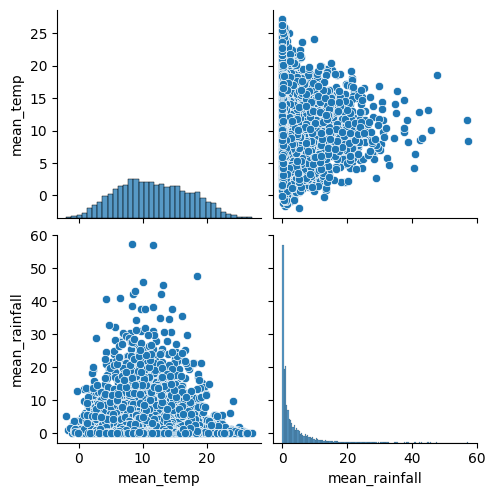

In [49]:
sns.pairplot(df[['mean_temp', 'mean_rainfall']])

<Axes: >

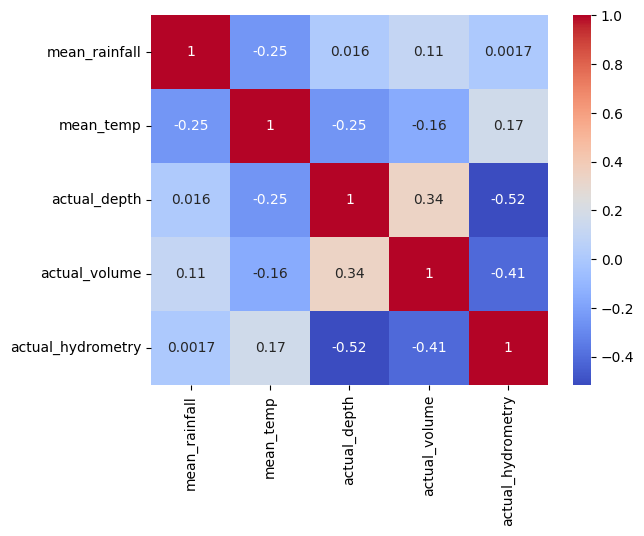

In [48]:
# Drop the column before computing correlation
corr = df.drop(columns='gap').corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')


### Visual Inspection

If two time series go up and down together, or when one rises and the other falls, you may have influence.



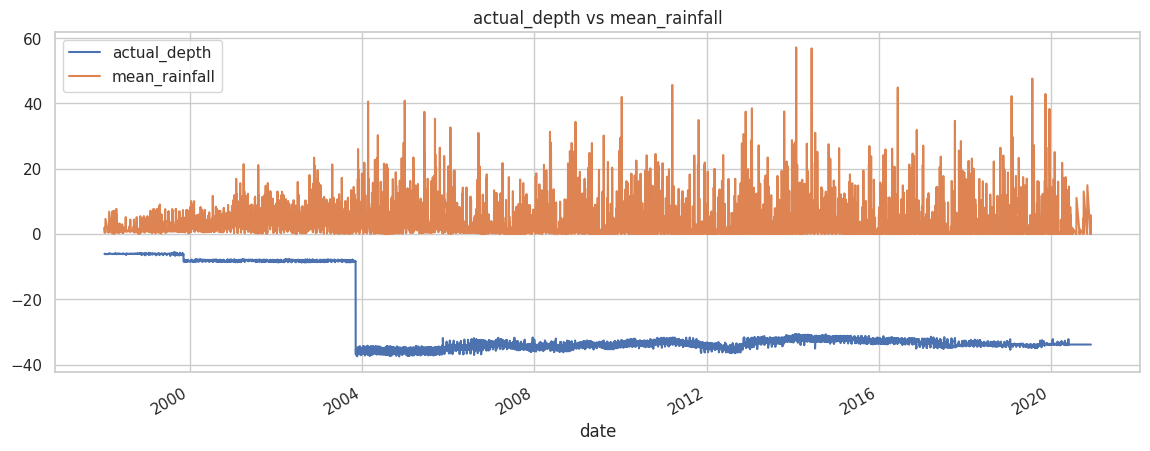

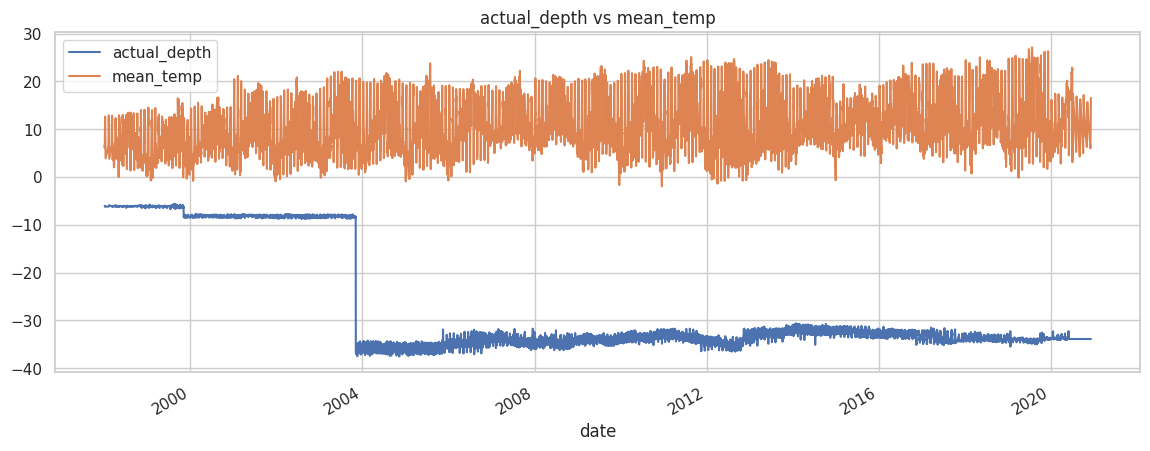

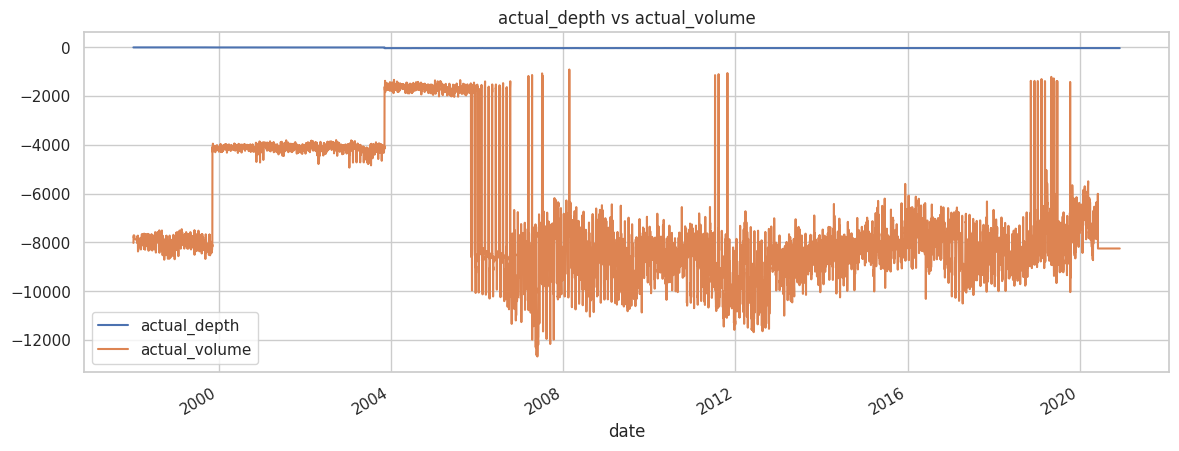

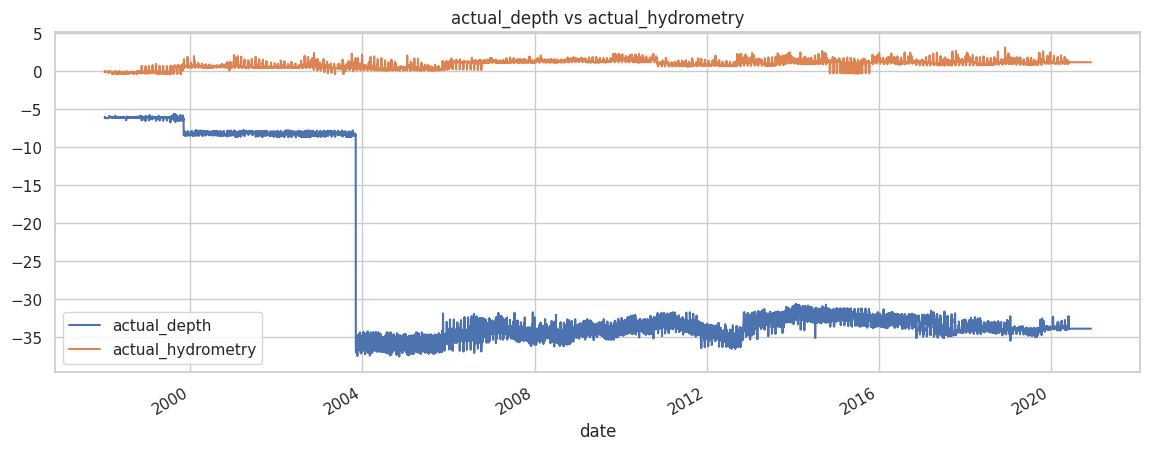

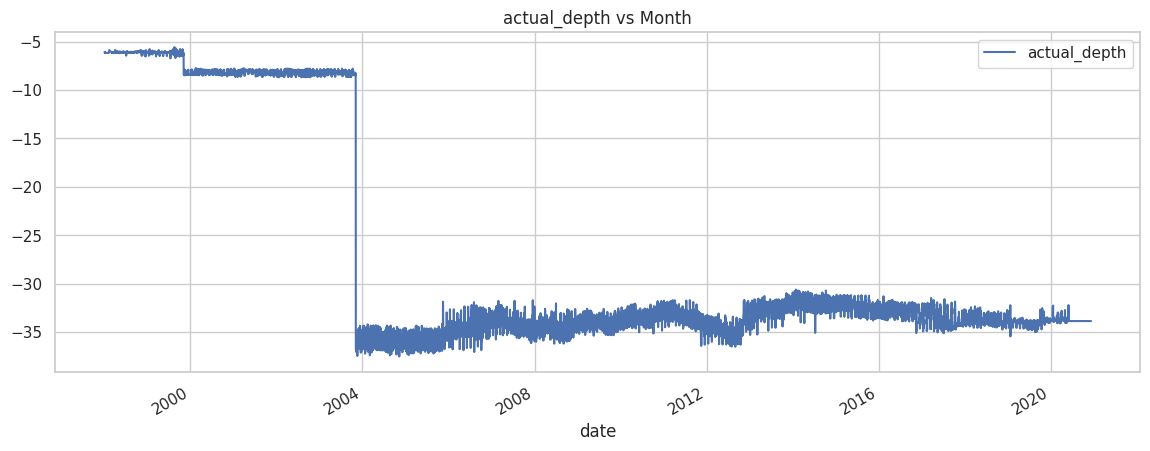

In [29]:
for col in df.columns:
    if col != 'actual_depth':
        df[['actual_depth', col]].plot(figsize=(14, 5), title=f'actual_depth vs {col}')


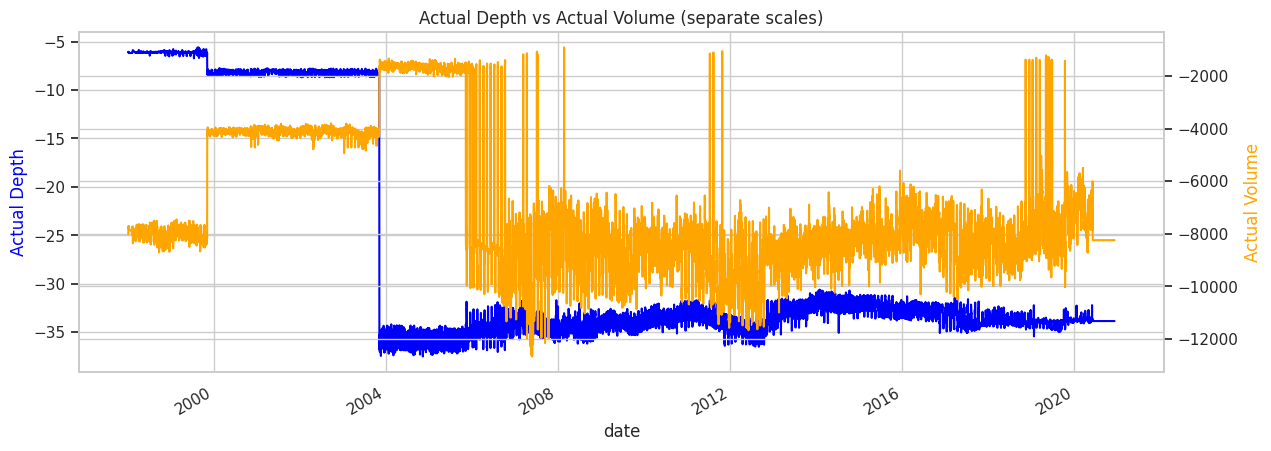

In [30]:
fig, ax1 = plt.subplots(figsize=(14, 5))

ax2 = ax1.twinx()
df['actual_depth'].plot(ax=ax1, color='blue', label='actual_depth')
df['actual_volume'].plot(ax=ax2, color='orange', label='actual_volume')

ax1.set_ylabel('Actual Depth', color='blue')
ax2.set_ylabel('Actual Volume', color='orange')
plt.title('Actual Depth vs Actual Volume (separate scales)')
plt.grid(True)
plt.show()


Normalize coth column so we can show them in one plot to see the correlation

<Axes: title={'center': 'Standardized Comparison'}, xlabel='date'>

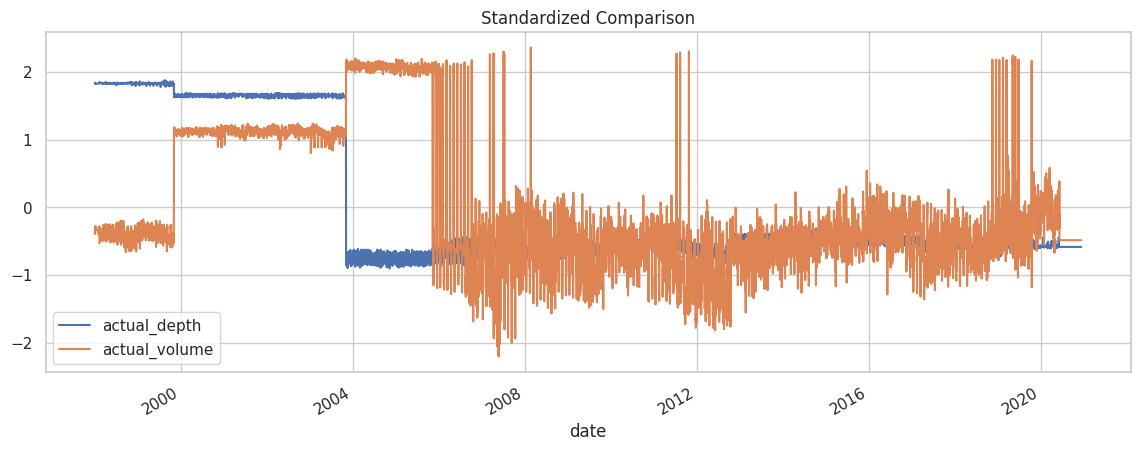

In [31]:
df[['actual_depth', 'actual_volume']].apply(
    lambda x: (x - x.mean()) / x.std()
).plot(figsize=(14, 5), title='Standardized Comparison')


If the points form a pattern (not random cloud), it shows relation.

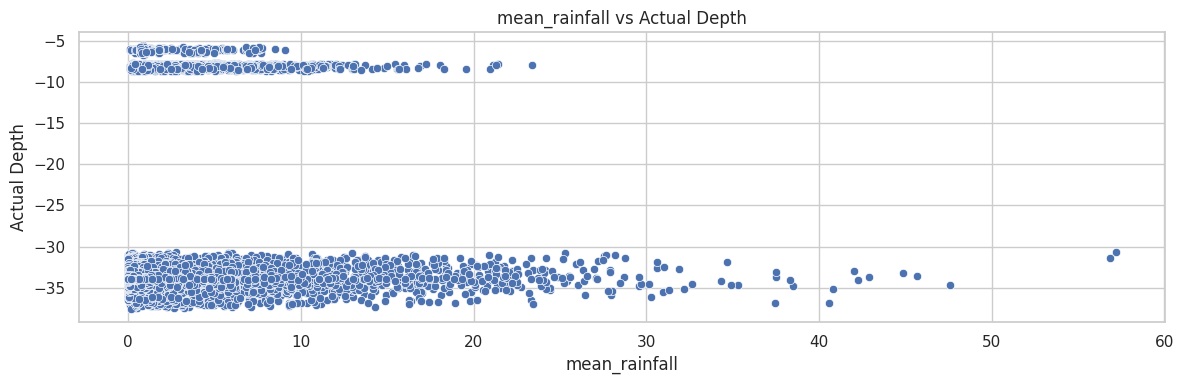

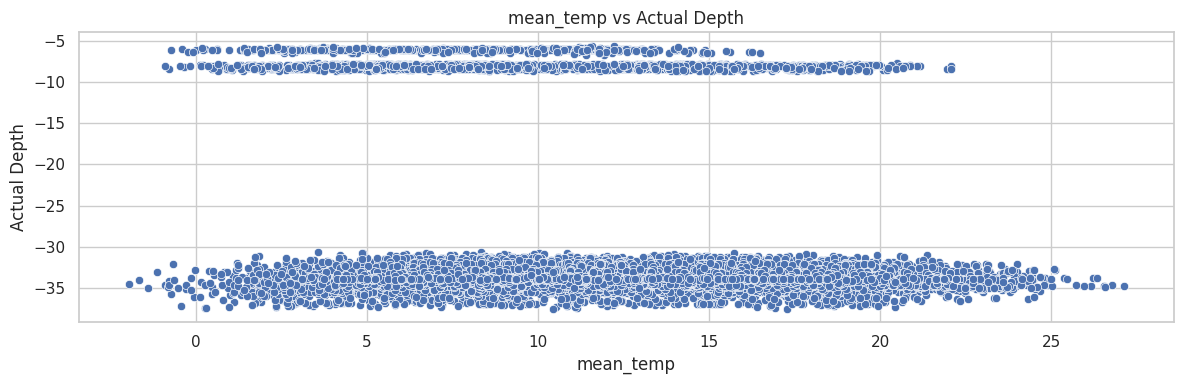

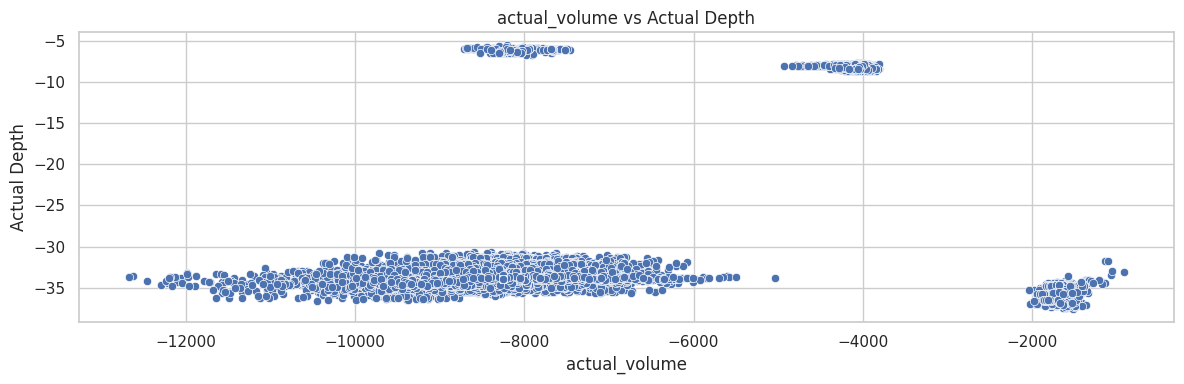

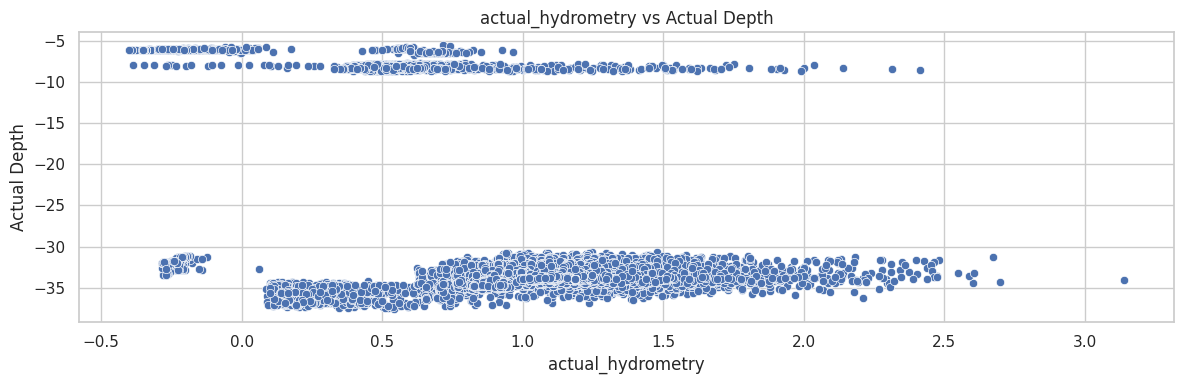

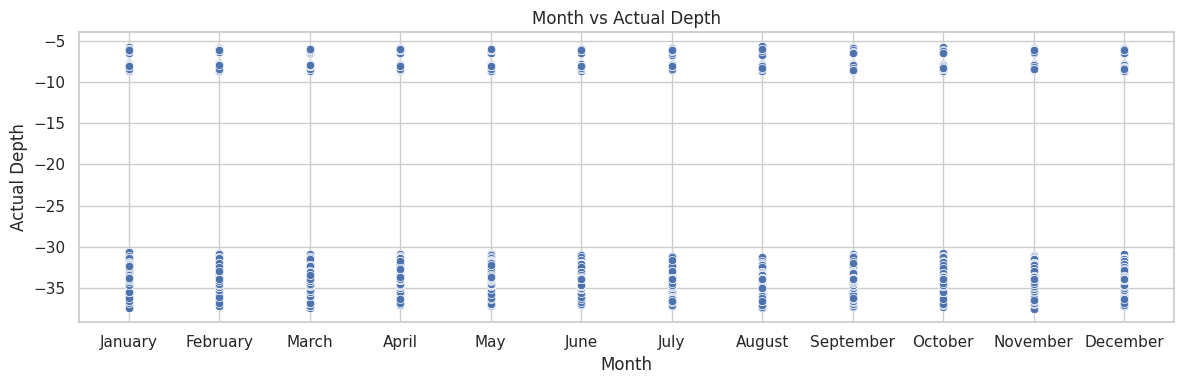

In [25]:
# @title
# Loop through all columns except 'actual_depth'
for col in df.columns:
    if col != 'actual_depth':
        plt.figure(figsize=(12, 4))
        sns.scatterplot(data=df, x=col, y='actual_depth')
        plt.title(f'{col} vs Actual Depth')
        plt.xlabel(col)
        plt.ylabel('Actual Depth')
        plt.tight_layout()
        plt.show()


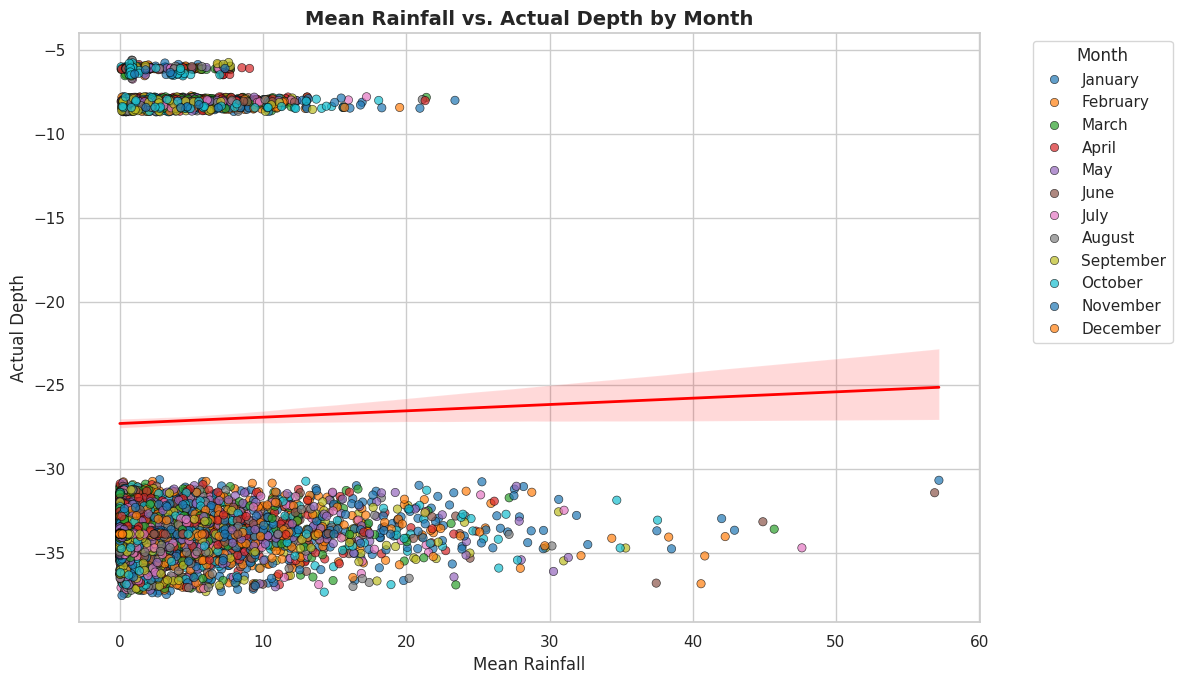

In [50]:
# @title
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add Month column for color grouping
df['Month'] = df.index.month_name()

# Set visual style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))

# Scatter plot with color coding
sns.scatterplot(
    data=df,
    x='mean_rainfall',
    y='actual_depth',
    hue='Month',
    palette='tab10',
    alpha=0.7,
    edgecolor='black'
)

# Optional: regression line
sns.regplot(
    data=df,
    x='mean_rainfall',
    y='actual_depth',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2}
)

# Optional: use log scale if needed
# plt.xscale('log')
# plt.yscale('log')

# Labels and title
plt.title('Mean Rainfall vs. Actual Depth by Month', fontsize=14, weight='bold')
plt.xlabel('Mean Rainfall', fontsize=12)
plt.ylabel('Actual Depth', fontsize=12)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Lagged Correlation (Influence with Delay)

Sometimes rainfall doesn’t affect depth immediately, but after a delay (e.g., water needs time to seep in).

You can test it like this:


🔁 Try .shift(7), .shift(14), .shift(90) to see where the best correlation appears.

In [54]:
max_lag = 30  # test up to 30 days
correlations = {}

for lag in range(1, max_lag + 1):
    shifted_temp = df['mean_rainfall'].shift(lag)
    correlations[lag] = df['actual_depth'].corr(shifted_temp)
    print(f"Lag {lag}: {correlations[lag]}")



Lag 1: 0.015530633468825765
Lag 2: 0.014289254500604729
Lag 3: 0.013952031460500796
Lag 4: 0.013223580368531909
Lag 5: 0.013342270636425834
Lag 6: 0.013762327677233874
Lag 7: 0.014939485137730935
Lag 8: 0.015642272768152853
Lag 9: 0.015020518978778468
Lag 10: 0.014350343340059286
Lag 11: 0.013726203403510204
Lag 12: 0.012727784955003903
Lag 13: 0.013067288956979992
Lag 14: 0.013692515068562908
Lag 15: 0.013457091219841648
Lag 16: 0.012999259508418435
Lag 17: 0.012364136508779872
Lag 18: 0.011973241597833098
Lag 19: 0.012062954725410203
Lag 20: 0.012495507364729461
Lag 21: 0.011119298917467626
Lag 22: 0.010763271745181052
Lag 23: 0.010910269200284666
Lag 24: 0.010376714785677563
Lag 25: 0.009914101895541604
Lag 26: 0.010490247189822707
Lag 27: 0.01015707566400881
Lag 28: 0.011324424346358901
Lag 29: 0.011624612791489944
Lag 30: 0.011878003644483161


In [53]:
max_lag = 30  # test up to 30 days
correlations = {}

for lag in range(1, max_lag + 1):
    shifted_temp = df['mean_temp'].shift(lag)
    correlations[lag] = df['actual_depth'].corr(shifted_temp)
    print(f"Lag {lag}: {correlations[lag]}")


# plt.figure(figsize=(12, 5))
# plt.plot(list(correlations.keys()), list(correlations.values()), marker='o')
# plt.title("Lagged Correlation: mean_temp vs. actual_depth")
# plt.xlabel("Lag in Days (mean_temp shifted)")
# plt.ylabel("Pearson Correlation")
# plt.grid(True)
# plt.axhline(0, color='gray', linestyle='--')
# plt.show()


Lag 1: -0.2535778069235007
Lag 2: -0.25281317907562734
Lag 3: -0.25175057241266
Lag 4: -0.2521042364153933
Lag 5: -0.253102784241216
Lag 6: -0.2550388023098645
Lag 7: -0.25573196028037437
Lag 8: -0.25615940370982954
Lag 9: -0.25496504368161205
Lag 10: -0.2537118032140097
Lag 11: -0.25225930012483055
Lag 12: -0.2507897076414889
Lag 13: -0.2500411270042074
Lag 14: -0.24972776266010352
Lag 15: -0.250079624381513
Lag 16: -0.2501047475819679
Lag 17: -0.24987424384732798
Lag 18: -0.25028302366877203
Lag 19: -0.25009060698306307
Lag 20: -0.25010319538707904
Lag 21: -0.2502231088547574
Lag 22: -0.25027753611889103
Lag 23: -0.25040362470568234
Lag 24: -0.2506892884249639
Lag 25: -0.25035688124426275
Lag 26: -0.2512415808760784
Lag 27: -0.2520389875969469
Lag 28: -0.2527637869183524
Lag 29: -0.25405251599351103
Lag 30: -0.25383361251763104


---
---
#### Result of lagged Correlation check for ***mean_temp*** and ***mean_rainfall***
---
---


| mean_temp             | Insight                                                   |
| -------------------- | --------------------------------------------------------- |
| Effect strength      | ❌ Weak (–0.25 range)                                      |
| Best lag             | Lag 7 (very slightly stronger)                            |
| Seasonal pattern?    | ❌ None visible in 30-day range                            |
| Useful in LSTM?      | ⚠️ Maybe — test with or without this feature              |
| Nature of dependency | Likely **non-linear**, **non-monotonic**, or **indirect** |


---
---
temp_mean is Useful in LSTM?  ==>  Maybe — test with or without this

---
---


### Statistical Tests (Advanced)

#### Granger Causality Test

#### Mutual Information

#### Feature Importance (RF, XGBoost)

## 5.Time Dependency Analysis

### Frequency check

8131 records occur at exactly 1-day intervals ==> dataset is primarily daily

Total anomalies: 23 rows

    Risk for Model Accuracy
    Models like ARIMA, Prophet, LSTM require uniform time intervals

    Gaps can lead to:
    Distorted trend/seasonality analysis
    Reduced prediction accuracy
    Misleading results if left uncorrected

In [20]:
print(df.index.freq)
# You may get None if:
# 1.Your index isn't a DatetimeIndex
# 2.Your time intervals are irregular
# 3.You didn’t set a frequency explicitly

None


#### Showing Irregularity in Time

In [10]:
df.index.to_series().diff().value_counts()

,count
date,
1 days,8131
3 days,8
7 days,6
26 days,3
25 days,2
4 days,1
23 days,1
20 days,1


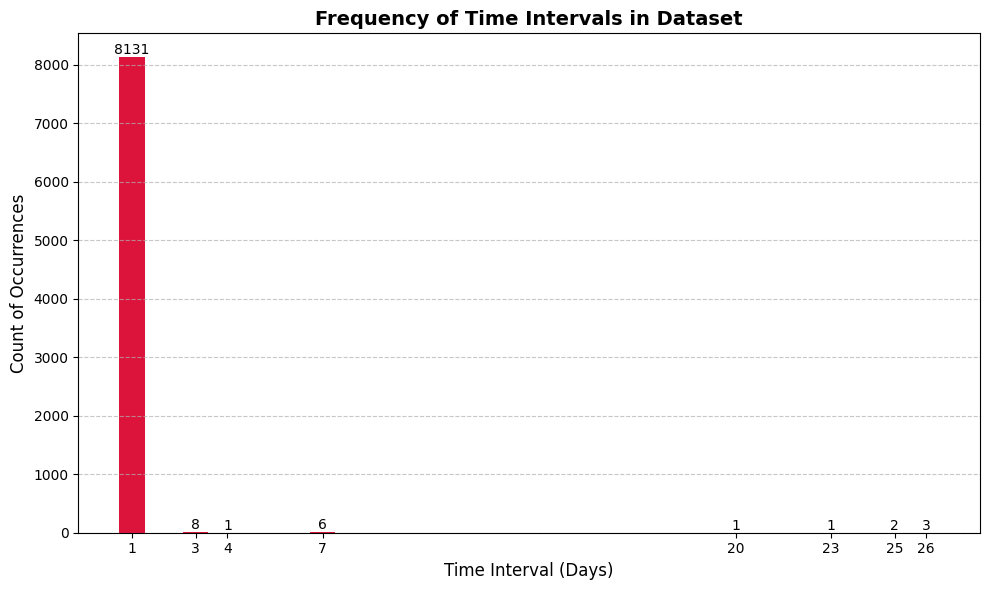

In [33]:
time_deltas = df.index.to_series().diff().value_counts().sort_index()
delta_days = time_deltas.index.days
counts = time_deltas.values

plt.figure(figsize=(10, 6))
bars = plt.bar(delta_days, counts, color='crimson')
plt.title('Frequency of Time Intervals in Dataset', fontsize=14, weight='bold')
plt.xlabel('Time Interval (Days)', fontsize=12)
plt.ylabel('Count of Occurrences', fontsize=12)
plt.xticks(delta_days)

for i in range(len(delta_days)):
    plt.text(delta_days[i], counts[i] + 0.5, str(counts[i]),
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [34]:
# Create DataFrame with previous date and gap
df_check = pd.DataFrame({
    'current_date': df.index,
    'previous_date': df.index.to_series().shift(1),
    'gap': df.index.to_series().diff()
})

# Filter where gap is not 1 day
irregular_gaps = df_check[df_check['gap'] != pd.Timedelta('1 days')]

print(irregular_gaps)


           current_date previous_date     gap
date                                         
1998-01-04   1998-01-04           NaT     NaT
1998-02-04   1998-02-04    1998-01-12 23 days
1998-03-04   1998-03-04    1998-02-12 20 days
1998-04-04   1998-04-04    1998-03-31  4 days
1998-05-03   1998-05-03    1998-04-30  3 days
1998-06-03   1998-06-03    1998-05-31  3 days
1998-07-03   1998-07-03    1998-06-30  3 days
1998-08-03   1998-08-03    1998-07-31  3 days
1998-09-03   1998-09-03    1998-08-31  3 days
1998-10-03   1998-10-03    1998-09-30  3 days
1998-11-03   1998-11-03    1998-10-31  3 days
1998-12-03   1998-12-03    1998-11-30  3 days
2020-01-13   2020-01-13    2020-01-06  7 days
2020-02-13   2020-02-13    2020-02-06  7 days
2020-03-13   2020-03-13    2020-03-06  7 days
2020-04-13   2020-04-13    2020-04-06  7 days
2020-05-13   2020-05-13    2020-05-06  7 days
2020-06-13   2020-06-13    2020-06-06  7 days
2020-08-01   2020-08-01    2020-07-06 26 days
2020-09-01   2020-09-01    2020-08

**How This Affects LSTM**

LSTMs require uniform frequency to learn time patterns.

So, this dataset:

Should be split before and after the 1998–2020 gap.

Or treated with resampling and interpolation to regularize it.

<ipython-input-17-b99b69d47540>:23: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


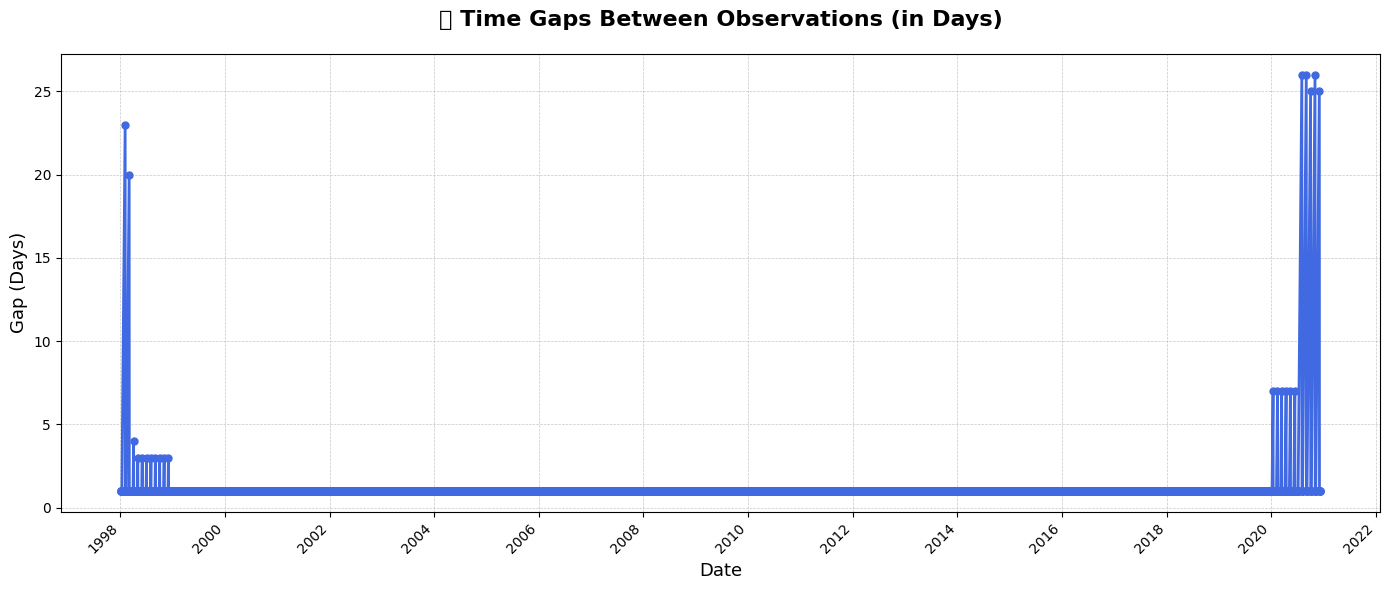

In [17]:
# Make sure 'gap' column exists
df['gap'] = df.index.to_series().diff().dt.days

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['gap'], marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=5)

# Titles and labels
plt.title('⏱️ Time Gaps Between Observations (in Days)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Gap (Days)', fontsize=13)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha='right')

# Grid and layout
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


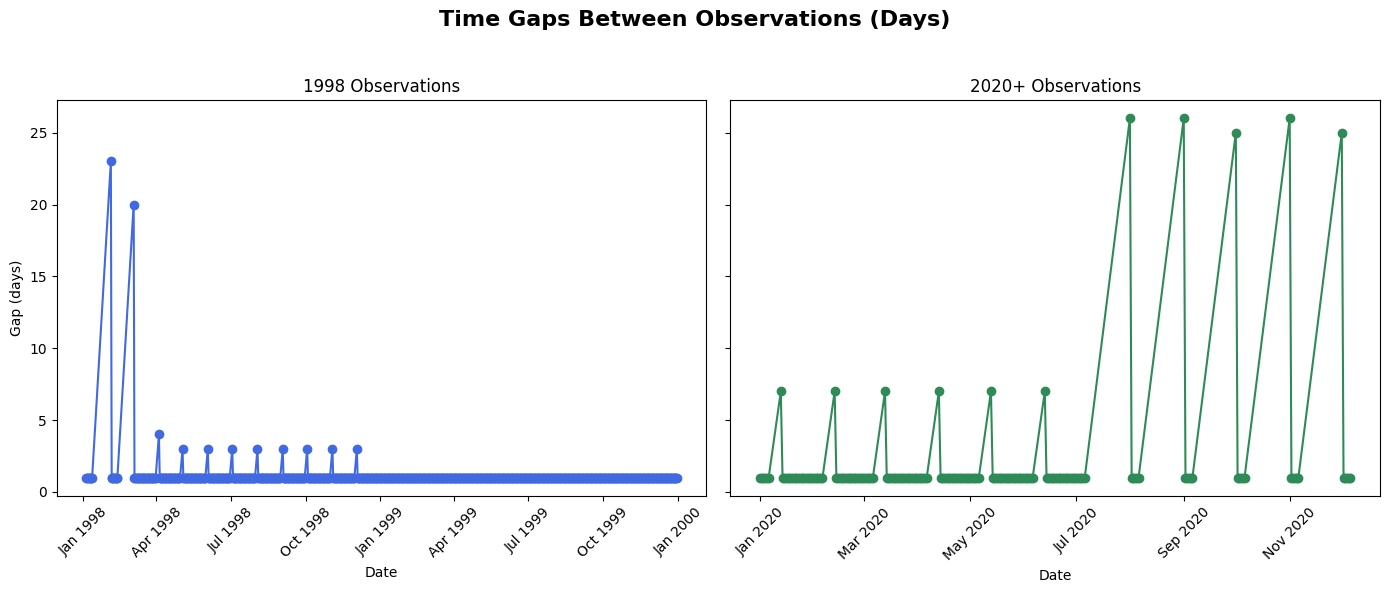

In [35]:
# Ensure gap column exists
df['gap'] = df.index.to_series().diff().dt.days

# Split the data
df_1998 = df[df.index.year < 2000]
df_2020 = df[df.index.year >= 2020]

# Create side-by-side plots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1]})

# Plot for 1998 data
ax1.plot(df_1998.index, df_1998['gap'], marker='o', color='royalblue')
ax1.set_title("1998 Observations")
ax1.set_xlabel("Date")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.tick_params(axis='x', rotation=45)

# Plot for 2020+ data
ax2.plot(df_2020.index, df_2020['gap'], marker='o', color='seagreen')
ax2.set_title("2020+ Observations")
ax2.set_xlabel("Date")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.tick_params(axis='x', rotation=45)

# Shared Y-axis
fig.suptitle("Time Gaps Between Observations (Days)", fontsize=16, fontweight='bold')
ax1.set_ylabel("Gap (days)")

# Add spacing and vertical line break
plt.subplots_adjust(wspace=0.15)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Show
plt.show()


#### Fix Irregularity in Time [ create new df (df ==> df_fixgaps) ]

**Since data is 98% daily and only ~1% irregular, the best, safe approach is:**

Reindex + Linear Interpolation, then proceed with modeling.

In [40]:
# 1. Create a full daily datetime index
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# 2. Reindex the DataFrame to include all dates
df_fixgap = df.reindex(full_index)

# 3. Optional: Add a flag to mark which rows were missing originally
df_fixgap['was_missing'] = df_fixgap.isna().any(axis=1).astype(int)

# 4. Interpolate missing values linearly
df_fixgap.interpolate(method='linear', inplace=True)

# 5. (Optional) Save cleaned data for modeling
df_fixgap.to_csv("daily_interpolated_ready.csv")


check new df_fixgap

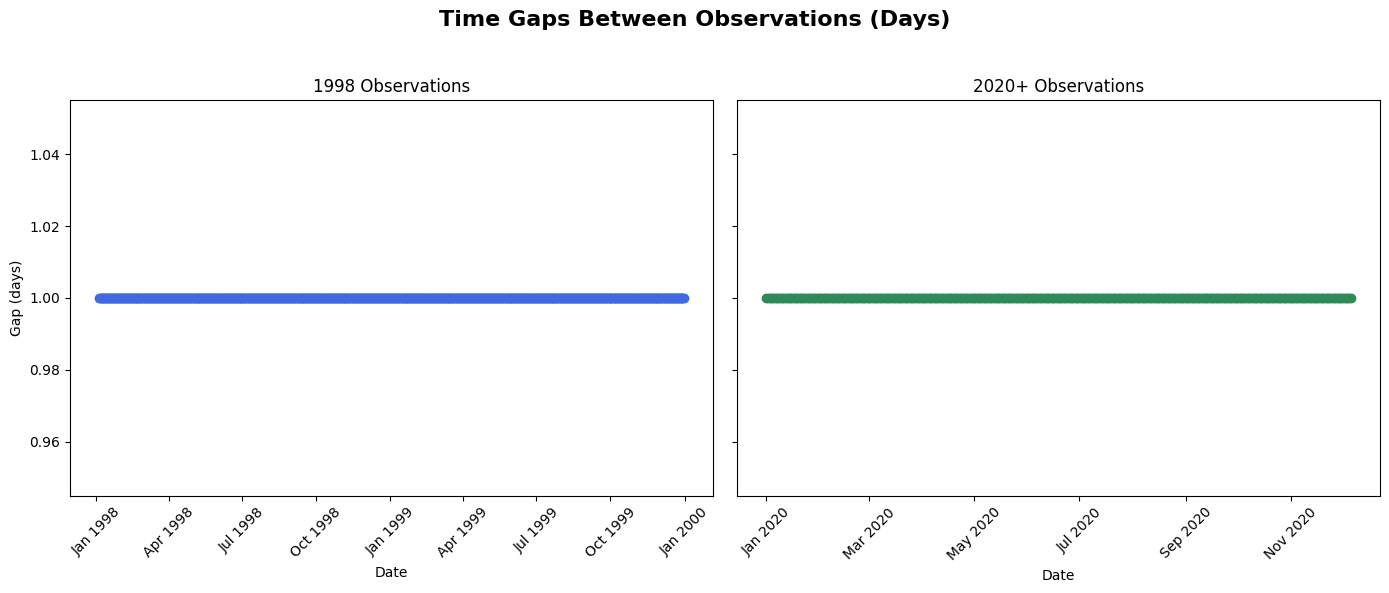

In [44]:
# Split the data
df_1998 = df_fixgap[df_fixgap.index.year < 2000]
df_2020 = df_fixgap[df_fixgap.index.year >= 2020]

# Create side-by-side plots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1]})

# Plot for 1998 data
ax1.plot(df_1998.index, df_1998['gap'], marker='o', color='royalblue')
ax1.set_title("1998 Observations")
ax1.set_xlabel("Date")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.tick_params(axis='x', rotation=45)

# Plot for 2020+ data
ax2.plot(df_2020.index, df_2020['gap'], marker='o', color='seagreen')
ax2.set_title("2020+ Observations")
ax2.set_xlabel("Date")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.tick_params(axis='x', rotation=45)

# Shared Y-axis
fig.suptitle("Time Gaps Between Observations (Days)", fontsize=16, fontweight='bold')
ax1.set_ylabel("Gap (days)")

# Add spacing and vertical line break
plt.subplots_adjust(wspace=0.15)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Show
plt.show()


### Trend Analysis

In [ ]:
columns = ['mean_rainfall', 'mean_temp', 'actual_depth', 'actual_volume','actual_hydrometry']
df_selected = df[columns].dropna(how='all')

# Create subplots
fig = sp.make_subplots(
    rows=len(columns), cols=1, shared_xaxes=True, vertical_spacing=0.03,
    subplot_titles=[col.replace('_', ' ').title() for col in columns]
)

# Add each column to its subplot
for i, col in enumerate(columns, start=1):
    fig.add_trace(
        go.Scatter(x=df_selected.index, y=df_selected[col], mode='lines', name=col),
        row=i, col=1
    )

# Update layout
fig.update_layout(
    height=250 * len(columns),
    title_text='Aquifer Variables Over Time (Interactive)',
    template='plotly_white',
    hovermode='x unified',
    showlegend=False
)

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Value')

fig.show()


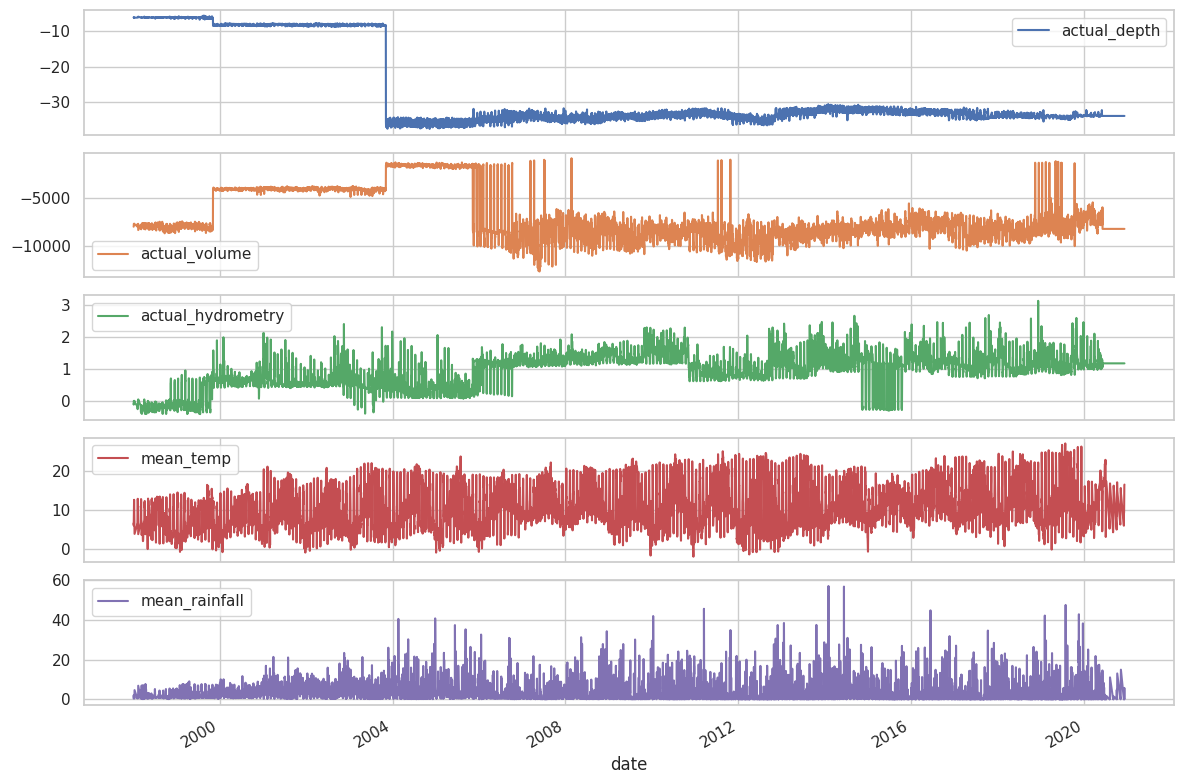

In [ ]:
df[['actual_depth', 'actual_volume', 'actual_hydrometry','mean_temp','mean_rainfall']].plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.show()


#### rolling average if data has outlier to remove them to prepare suitable entry for lstm model

In [ ]:
df['depth_rolling'] = df['actual_depth'].rolling(window=90).mean()
print (df['depth_rolling'])

date
2022-01-01      NaN
2022-01-02      NaN
2022-01-03      NaN
2022-01-04      NaN
2022-01-05      NaN
              ...  
2022-10-23    15.01
2022-10-24    15.03
2022-10-25    15.05
2022-10-26    15.07
2022-10-27    15.09
Freq: D, Name: depth_rolling, Length: 300, dtype: float64


In [ ]:
# Compute 90-day rolling average
df['rolling_depth'] = df['actual_depth'].rolling(window=90).mean()
df_clean = df.dropna(subset=['rolling_depth'])

# Convert index to Series for shaded area
index_series = pd.Series(df_clean.index)

# Create interactive plot
fig = go.Figure()

# Actual Depth line
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['actual_depth'],
    mode='lines',
    name='Actual Depth (Daily)',
    line=dict(color='steelblue', width=1),
    opacity=0.4
))

# Rolling Mean line
fig.add_trace(go.Scatter(
    x=df_clean.index,
    y=df_clean['rolling_depth'],
    mode='lines',
    name='90-Day Rolling Mean',
    line=dict(color='crimson', width=3)
))

# Shaded area under rolling mean
fig.add_trace(go.Scatter(
    x=pd.concat([index_series, index_series[::-1]]),
    y=pd.concat([df_clean['rolling_depth'], pd.Series([0]*len(df_clean))]),
    fill='toself',
    fillcolor='rgba(220, 20, 60, 0.1)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='Shaded Area'
))

# Start and End markers
fig.add_trace(go.Scatter(
    x=[df.index[0]],
    y=[df['actual_depth'].iloc[0]],
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='Start Point'
))
fig.add_trace(go.Scatter(
    x=[df.index[-1]],
    y=[df['actual_depth'].iloc[-1]],
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='End Point'
))

# Vertical line and annotation
highlight_date = df_clean.index[0]
highlight_value = df_clean['rolling_depth'].iloc[0]
fig.add_shape(type="line", x0=highlight_date, x1=highlight_date,
              y0=df['actual_depth'].min(), y1=df['actual_depth'].max(),
              line=dict(color="gray", dash="dash"))
fig.add_annotation(x=highlight_date, y=highlight_value + 1,
                   text="Start of Trend", showarrow=True, arrowhead=1)

# Layout customization
fig.update_layout(
    title='Interactive Groundwater Depth Trend (Smoothed vs. Daily)',
    xaxis_title='Date',
    yaxis_title='Actual Depth (m)',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    template='plotly_white',
    height=600
)

fig.show()


<Axes: xlabel='date'>

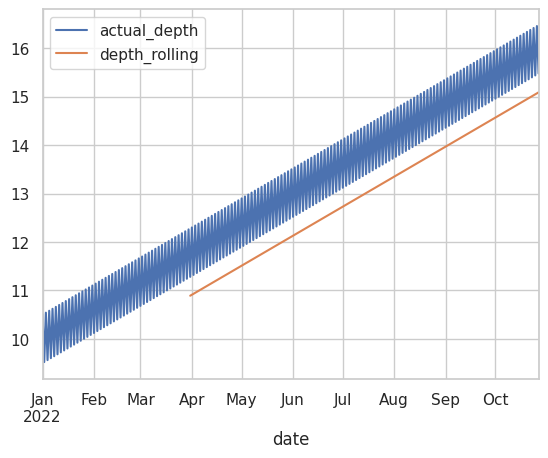

In [ ]:
df[['actual_depth','depth_rolling']].plot()


In [ ]:
df.columns

Index(['actual_depth', 'depth_rolling', 'rolling_depth'], dtype='object')

In [ ]:
df.corr()['actual_depth'].sort_values()


## 6.Stationary Analysis

## 7.Gaussian (Normality) Analysis

## 8.Data Scaling

## 9.Windowing / Sequencing

## 10.Sequence Length Tuning

## 11.Train/Test Splitting

## 12.Input Shape Verification